Proyecto Poster - Red Clasificación Ropa
==

El objetivo de este trabajo es crear una red neuronal para clasificar vestimenta.  Este es el proyecto final de la clase Clasificación y Reconocimiento de Patrones de la Universidad Nacional de Colombia Medellin (2019-2020)

### Cargue de librerias


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import confusion_matrix
import warnings

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

In [2]:
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

### Cargue de datos

El conjunto de datos son 17117 imagenes de prendas de vestir clasificadas en 19 clases.  Este está desbalanceado, lo que implicará hacer ampliación de datos, para este ejercicio en particular, usaremos las funciones de open cv para crear más imagenes. 

In [3]:
#se listan los nombres de las cartetas con la ropa clasificada en categorías
CATEGORIES = os.listdir("Input")
CATEGORIES

['HOMBRE-BUSO',
 'HOMBRE-CAMISA',
 'HOMBRE-CAMISETA',
 'HOMBRE-CHAQUETA',
 'HOMBRE-JOGGER',
 'HOMBRE-PANTALÓN',
 'HOMBRE-POLO',
 'HOMBRE-SHORT',
 'HOMBRE-TANK',
 'MUJER-BUSO',
 'MUJER-CAMISA',
 'MUJER-CHAQUETA',
 'MUJER-FALDA',
 'MUJER-JOGGER',
 'MUJER-PANTALÓN',
 'MUJER-SHORT',
 'MUJER-TOP',
 'MUJER-TOP ML',
 'MUJER-VESTIDO']

In [4]:
#se crea un listado sin las dos categorias con más datos.  A las demás se les realziará Data Aumentation
CATEGORIES_2 = list(categiorie for categiorie in CATEGORIES if categiorie != 'MUJER-TOP' and  categiorie != 'HOMBRE-CAMISETA')
#list( myBigList[i] for i in [87, 342, 217, 998, 500] )
print(len(CATEGORIES),len(CATEGORIES_2 ))
CATEGORIES_2

19 17


['HOMBRE-BUSO',
 'HOMBRE-CAMISA',
 'HOMBRE-CHAQUETA',
 'HOMBRE-JOGGER',
 'HOMBRE-PANTALÓN',
 'HOMBRE-POLO',
 'HOMBRE-SHORT',
 'HOMBRE-TANK',
 'MUJER-BUSO',
 'MUJER-CAMISA',
 'MUJER-CHAQUETA',
 'MUJER-FALDA',
 'MUJER-JOGGER',
 'MUJER-PANTALÓN',
 'MUJER-SHORT',
 'MUJER-TOP ML',
 'MUJER-VESTIDO']

In [5]:
#conteo de numero de imagenes por carpeta
cont_1 = 0
cont_2 = 0
for folder in os.listdir("Input"):
    aux_rootDir = os.path.join('Input',folder)
    for file in os.listdir(aux_rootDir):
        cont_1 += 1
    cont_2 += cont_1
    print('By class',folder, ": "  , cont_1 , ' and accumulated:', cont_2 )
    cont_1 = 0

By class HOMBRE-BUSO :  651  and accumulated: 651
By class HOMBRE-CAMISA :  268  and accumulated: 919
By class HOMBRE-CAMISETA :  4279  and accumulated: 5198
By class HOMBRE-CHAQUETA :  94  and accumulated: 5292
By class HOMBRE-JOGGER :  286  and accumulated: 5578
By class HOMBRE-PANTALÓN :  380  and accumulated: 5958
By class HOMBRE-POLO :  551  and accumulated: 6509
By class HOMBRE-SHORT :  298  and accumulated: 6807
By class HOMBRE-TANK :  732  and accumulated: 7539
By class MUJER-BUSO :  659  and accumulated: 8198
By class MUJER-CAMISA :  624  and accumulated: 8822
By class MUJER-CHAQUETA :  106  and accumulated: 8928
By class MUJER-FALDA :  279  and accumulated: 9207
By class MUJER-JOGGER :  340  and accumulated: 9547
By class MUJER-PANTALÓN :  402  and accumulated: 9949
By class MUJER-SHORT :  413  and accumulated: 10362
By class MUJER-TOP :  4813  and accumulated: 15175
By class MUJER-TOP ML :  803  and accumulated: 15978
By class MUJER-VESTIDO :  1139  and accumulated: 17117


In [6]:
#Se define la funcion para manualmente hacer Data Augmentation usando libreria cv
def loadTrainingData(rootDir, IMG_S):
    count_1=0
    count_2=0
    count_3=0
    path_t = rootDir
    for categorie in CATEGORIES:
        PATH = os.path.join(path_t,categorie)
        class_num = CATEGORIES.index(categorie)
        for img in os.listdir(PATH):
            image = os.path.join(PATH, img)
            image = cv2.imread(image, cv2.IMREAD_ANYCOLOR)
            image = cv2.resize(image , (IMG_S, IMG_S))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X.append(image)
            Y.append(class_num)
            count_1 +=1
            count_2 +=1
            
            if categorie != 'MUJER-TOP' and categorie != 'HOMBRE-CAMISETA':           
                X.append(cv2.flip(image, 0))  # La diferencia con 1 y -1, es q' este hace un giro completo en espejo
                Y.append(class_num)
                count_2 +=1 
                X.append(cv2.flip(image, 1))  # Vertical, que se hizo en la ampliación de datos
                Y.append(class_num)
                count_2 +=1 
                X.append(cv2.flip(image, -1)) # horizontal, que se hizo en la ampliación de datos
                Y.append(class_num)                
                count_2 +=1 
                X.append(cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE))
                Y.append(class_num)
                count_2 +=1 
                
                if len(os.listdir(PATH))<700: 
                    
                    X.append(cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE))
                    Y.append(class_num)
                    count_2 +=1 

                    lookUpTable = np.empty((1,256), np.uint8)

                    gamma = np.random.random_integers(20,70)/100                

                    for i in range(256):
                        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

                    X.append(cv2.LUT(image, lookUpTable))
                    Y.append(class_num)
                    count_2 +=1   
                
                if len(os.listdir(PATH))<500:   
                    
                    alpha = np.random.random_integers(60, 90+1)/100
                    beta =  np.random.random_integers(30, 90)


                    X.append(cv2.convertScaleAbs(image, alpha=1, beta=beta))
                    Y.append(class_num)
                    count_2 +=1                
                    X.append(cv2.convertScaleAbs(image, alpha=alpha, beta=0))
                    Y.append(class_num)
                    count_2 +=1                 
                    X.append(cv2.convertScaleAbs(image, alpha=alpha, beta=beta))
                    Y.append(class_num)
                    count_2 +=1


                
        count_3 += count_2
        print('By class',categorie, " images: ", count_1, " augmented:", count_2 , ' and accumulated:', count_3 )
        count_1 = 0
        count_2 = 0

In [4]:
X=[]
Y=[]
IMG_S = 128
rootDir = "Input"

In [1]:
loadTrainingData(rootDir, IMG_S)  #data augmentation

In [ ]:
# Se reescalan las imagenes
X = np.array(X)/255.
Y = np.array(Y)
X.shape

In [ ]:
#Manualmente se generan vectores one hot para las categorías
def one_hottie(labels,C):
    One_hot_matrix = tf.one_hot(labels,C)
    return tf.keras.backend.eval(One_hot_matrix)
Y = one_hottie(Y, len(CATEGORIES))
print ("Y shape: " + str(Y.shape))

In [ ]:
#plt.axis('off')
#plt.imshow(X[4368])

In [ ]:
#Se usa sklearn para dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 0)
del X
del Y

In [5]:
# Hands-On Convolutional Neural Networks with TensorFlow VGG16 - Se define la estructura de la red neuronal

i = Input(shape = (IMG_S,IMG_S,3))
x = Conv2D(128, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)

#x = Dropout(0.2)(x)
#x = Dense(4096, activation = 'relu', kernel_regularizer= l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation = 'relu', kernel_regularizer= l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu', kernel_regularizer= l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(19, activation = 'softmax', kernel_regularizer= l2(0.001))(x)

model = Model(i ,x)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       295168

In [ ]:
#se define una función para evaluación de accuracy, usando la librería de keras
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

#def top_2_accuracy(y_true, y_pred):
#    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
#Definición de tasa de aprendizaje, y otros hiperparametros
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2145,
    decay_rate=0.9,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
Y_train.shape

In [7]:
filepath = "./saved_model/modelo_04_100_epochs_vgg16_modificado_2_sin_transfer_data_ampl.h5"  #nommbre del archivo donde se guardará el mejor modelo

In [20]:
#Para guardar automaticamente el mejor modelo de forma iterativa
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

In [21]:
callbacks_list = [checkpoint]

In [22]:
BATCHES = 64
EPOCHS = 55

In [23]:
result = model.fit(x=X_train,
                   y=Y_train,
                   batch_size=BATCHES,
                   epochs=EPOCHS,
                   verbose=1,
                   shuffle=False,
                   initial_epoch=0,
                   validation_split=0.125,
                   callbacks=callbacks_list)
# 11:20

Train on 50959 samples, validate on 7280 samples
Epoch 1/55
50944/50959 [============================>.] - ETA: 0s - loss: 3.3640 - accuracy: 0.4008
Epoch 00001: val_accuracy improved from -inf to 0.25701, saving model to modelo_04_100_epochs_vgg16_modificado_2_sin_transfer_data_ampl.h5
50959/50959 [==============================] - 492s 10ms/sample - loss: 3.3635 - accuracy: 0.4009 - val_loss: 2.9072 - val_accuracy: 0.2570
Epoch 2/55
50944/50959 [============================>.] - ETA: 0s - loss: 1.4399 - accuracy: 0.6308
Epoch 00002: val_accuracy improved from 0.25701 to 0.66703, saving model to modelo_04_100_epochs_vgg16_modificado_2_sin_transfer_data_ampl.h5
50959/50959 [==============================] - 480s 9ms/sample - loss: 1.4398 - accuracy: 0.6308 - val_loss: 1.2978 - val_accuracy: 0.6670
Epoch 3/55
50944/50959 [============================>.] - ETA: 0s - loss: 1.0552 - accuracy: 0.7233
Epoch 00003: val_accuracy did not improve from 0.66703
50959/50959 [=======================

In [15]:
result.history.keys()

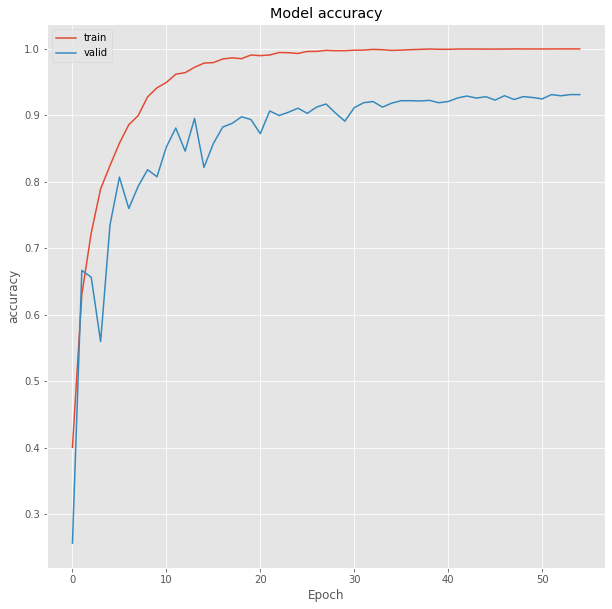

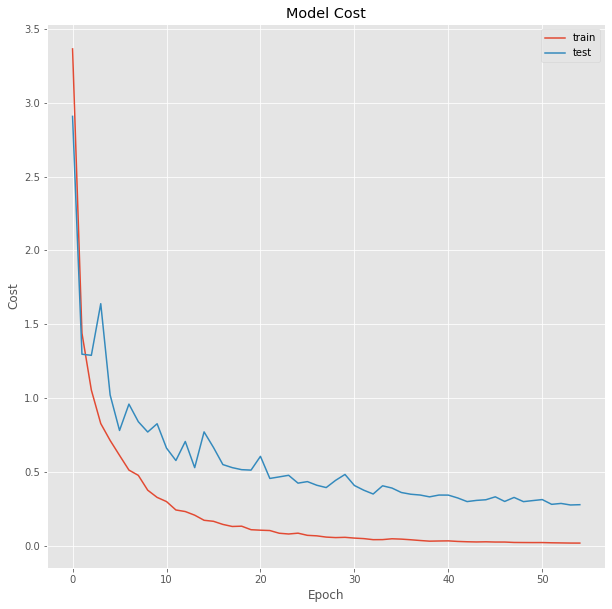

In [26]:
plt.figure(figsize = (10,10))
plt.plot(result.history['accuracy'], label='train')
plt.plot(result.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()
plt.figure(figsize = (10,10))
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

### Evaluation on test set

In [16]:
model = tf.keras.models.load_model('./saved_model/modelo_04_100_epochs_vgg16_modificado_2_sin_transfer_data_ampl.h5') #se carga el modelo y sus pesos

In [27]:
valid = model.evaluate(X_test,Y_test,verbose=2)

10278/1 - 40s - loss: 0.1746 - accuracy: 0.9269


In [28]:
Records = []
Records.append(valid)

In [29]:
Records

[[0.29769996887261035, 0.9269313]]

### Making Predictions

In [30]:
predict = model.predict(X_test)
y_valid_pred_class = np.argmax(predict, axis = 1)

In [31]:
y_valid_pred_class

array([ 2,  8,  5, ...,  6,  2, 12])

In [32]:
Y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
Y_test_A = np.argmax(Y_test, axis = 1)

In [34]:
Y_test_A

array([ 2,  8,  1, ...,  6,  2, 12])

In [35]:
cnf_matrix = confusion_matrix(Y_test_A, y_valid_pred_class)

In [36]:
cnf_matrix

array([[568,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   7],
       [  0, 552,   1,   0,  20,   3,  22,   0,   8,   0,   0,   8,   2,
          1,   0,  10,   0,   0,   2],
       [  0,   1, 476,   1,   0,   0,   1,   0,   0,   1,  16,   1,   0,
          0,   0,   0,   7,   0,   1],
       [  1,   0,   2, 513,   0,   0,   1,   0,   0,   1,  11,   0,   0,
          0,   0,   0,  13,   0,   0],
       [  0,  20,   0,   0, 491,   2,  67,   0,   3,   0,   0,  10,   0,
          1,   1,   5,   0,   0,   0],
       [  0,   0,   0,   1,   5, 612,  28,   4,   0,   0,   1,   0,   4,
          4,   2,   0,   0,   7,   2],
       [  0,  18,   1,   1,  53,   8, 619,   0,   5,   0,   0,   3,   2,
          0,   0,  14,   0,   0,   0],
       [  0,   2,   0,   0,   0,   3,   2, 557,   1,   0,   0,   1,   4,
          0,   4,   0,   0,   2,   2],
       [  1,   4,   0,   0,   6,   0,   0,   1, 682,   1,   0,  14,   0,
          0,   6,   0,   0,   4

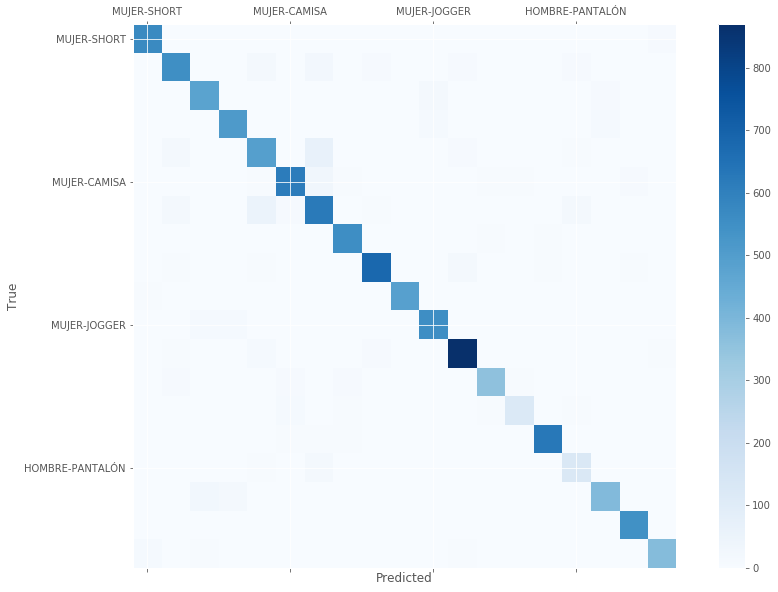

In [37]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix,  cmap = 'Blues')
fig.colorbar(cax)
ax.set_xticklabels([''] + CATEGORIES)
ax.set_yticklabels([''] + CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

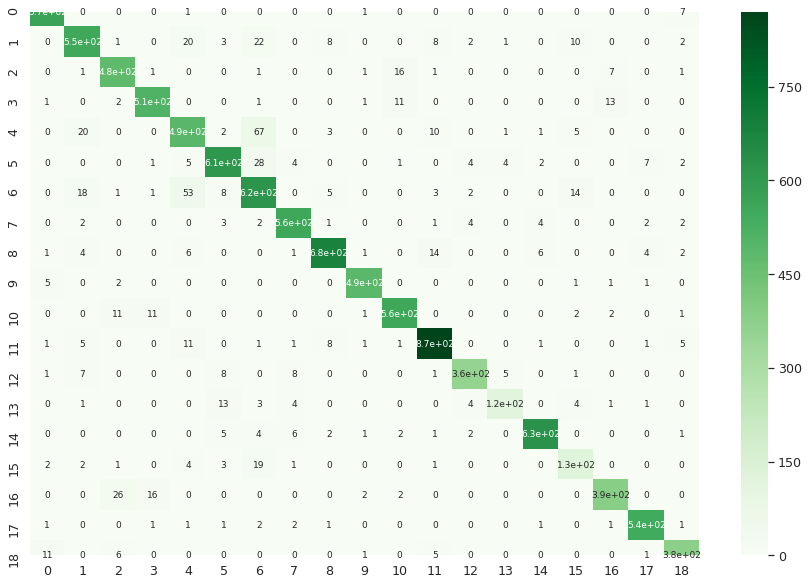

In [38]:
import seaborn as sn

plt.figure(figsize=(15,10))
df_cm = pd.DataFrame(cnf_matrix)

sn.set(font_scale=1.15) # for label size
sn.heatmap(df_cm, annot=True, cmap = 'Greens',annot_kws={"size": 9}) # font size